# CITATION Location - clustering analysis

### Process:

1. Subset the dataset based on **top locations** and **top citations**

1. For each citation - examine for age, location, time of day clusters

1. For each location:
    examine for age, time of day, citation type clusters

1. For each hour of the day:
    examine for age, citation type, and location clusters


for each of these find the highest silhouette score for that particular citation, location, hour of the day


## IMPORT LIBRARIES AND DATA

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import glob
pd.set_option('display.max_columns', None)
sns.set(style='darkgrid')
# plt.style.use('bmh')
plt.rcParams['patch.edgecolor'] = 'none'
import jenkspy

import hdbscan
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read in data that has already been preprocessed
df = pd.read_csv('data/clustering_features.csv')

In [3]:
df.shape

(36626, 11)

In [4]:
df.head()

,beat,cited_person_age,citation_time,charge_description,street,month,day_of_week,week_of_year,hour_of_day,place_id,age_breaks
0,12.0,19.0,747,Speed Greater Than R&P or Posted,E Shea Bl,7,2,28,7,E Shea Bl - 6xxx,"(17.999, 24.0]"
1,12.0,36.0,800,Speed Greater Than R&P or Posted,E Shea Bl,7,2,28,8,E Shea Bl - 6xxx,"(30.0, 39.0]"
2,7.0,61.0,853,Speed Greater Than R&P or Posted,N Goldwater Bl,7,2,28,8,N Goldwater Bl - 4xxx,"(51.0, 97.0]"
3,7.0,59.0,843,Speed Greater Than R&P or Posted,N Goldwater Bl,7,3,28,8,N Goldwater Bl - 4xxx,"(51.0, 97.0]"
4,19.0,23.0,2215,Speed Greater Than R&P or Posted,N Pima Rd,7,5,27,22,N Pima Rd - 2xxx,"(17.999, 24.0]"


In [11]:
# drop place id for the time being
df.drop(['place_id'], axis=1, inplace=True)

In [5]:
# drop features I don't want to use for now
df.drop(['citation_time'], axis=1, inplace=True)
# df.drop(['age_breaks'], axis=1, inplace=True)
# df.drop(['beat'], axis=1, inplace=True)
df.drop(['cited_person_age'], axis=1, inplace=True)

In [6]:
df.drop(['street'], axis=1, inplace=True)

In [7]:
# drop citations where beat is null
# otherwise this creates problems for modeling

df.drop(df[df.beat.isnull()].index, inplace=True)

In [8]:
# verify no null values remain
df.isnull().sum()

beat                  0
charge_description    0
month                 0
day_of_week           0
week_of_year          0
hour_of_day           0
place_id              0
age_breaks            0
dtype: int64

In [13]:
df.head()

,beat,charge_description,month,day_of_week,week_of_year,hour_of_day,age_breaks
0,12.0,Speed Greater Than R&P or Posted,7,2,28,7,"(17.999, 24.0]"
1,12.0,Speed Greater Than R&P or Posted,7,2,28,8,"(30.0, 39.0]"
2,7.0,Speed Greater Than R&P or Posted,7,2,28,8,"(51.0, 97.0]"
3,7.0,Speed Greater Than R&P or Posted,7,3,28,8,"(51.0, 97.0]"
4,19.0,Speed Greater Than R&P or Posted,7,5,27,22,"(17.999, 24.0]"


In [292]:
# identify unique beat locations
df.beat.unique()

array([12.,  7., 19., 11.,  6., 14., 10., 18.,  3., 15.,  1., 16., 17.,
       13., 99.,  4., 20.,  8.,  5.,  9.,  2.])

In [16]:
X = pd.get_dummies(df.drop(['beat'], axis=1))

In [17]:
X.head()

,month,day_of_week,week_of_year,hour_of_day,charge_description_DUI-Impaired to Slightest Degree,charge_description_Drug Paraphernalia-Possess/Use,charge_description_Expired/No Arizona Registration,charge_description_Fail to Obey Traffic Control Device,charge_description_Fail to Stop For Red Signal,charge_description_Fail to Stop at Stop Sign,charge_description_Failure to Control Speed to Avoid A Collision,charge_description_No Proof of Insurance,charge_description_Speed Greater Than R&P or Posted,charge_description_Suspended/Revoked D.L.,"age_breaks_(17.999, 24.0]","age_breaks_(24.0, 30.0]","age_breaks_(30.0, 39.0]","age_breaks_(39.0, 51.0]","age_breaks_(51.0, 97.0]"
0,7,2,28,7,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,7,2,28,8,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,7,2,28,8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,7,3,28,8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,7,5,27,22,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [18]:
X.shape

(36391, 19)

In [18]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [247]:
sil_score = []
cluster_count = []

for location in list(df.beat.unique()):
    
    df2 = df[df.beat == location]
    X = pd.get_dummies(df2.drop(['beat'], axis=1))
    
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    
    # Defining the agglomerative clustering
    dbscan_cluster = DBSCAN(eps=.5, min_samples=5)

    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    
    # capture cluster count
    cluster_count.append(len(set(clusters)) - (1 if -1 in clusters else 0))

    # capture model fit
    if pd.Series(clusters).nunique() > 1:
        sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))
    else:
        sil_score.append(np.nan)

In [248]:
list(zip(list(df.beat.unique()), sil_score, cluster_count))

[(12.0, -0.324, 17),
 (7.0, -0.274, 58),
 (19.0, -0.265, 83),
 (11.0, -0.195, 3),
 (6.0, -0.308, 86),
 (14.0, -0.249, 18),
 (10.0, -0.245, 45),
 (18.0, -0.255, 21),
 (3.0, -0.364, 26),
 (15.0, -0.325, 30),
 (1.0, -0.21, 7),
 (16.0, 0.024, 3),
 (17.0, -0.239, 40),
 (13.0, -0.276, 9),
 (99.0, nan, 0),
 (4.0, -0.297, 29),
 (20.0, -0.202, 39),
 (8.0, -0.261, 17),
 (5.0, -0.208, 9),
 (9.0, -0.328, 7),
 (2.0, -0.263, 9)]

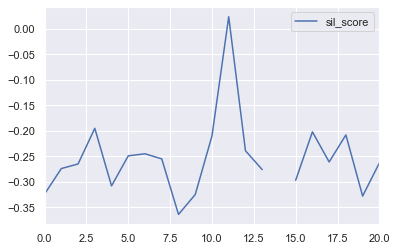

In [249]:
pd.DataFrame(list(zip(list(df.beat.unique()), sil_score, cluster_count)), 
            columns=['beat', 'sil_score', 'cluster_count']).loc[:,['sil_score']].plot()

# plt.ylabel('Score Index')
# plt.xlabel('Clusters')
# plt.xticks(rotation=45);

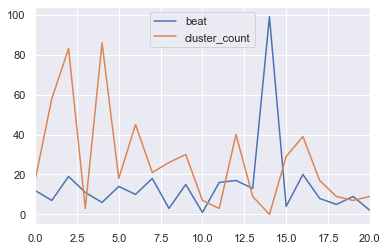

In [242]:
pd.DataFrame(list(zip(list(df.beat.unique()), sil_score, cluster_count)), 
            columns=['beat', 'sil_score', 'cluster_count']).loc[:,['beat','cluster_count']].plot()

# plt.ylabel('Score Index')
# plt.xlabel('Clusters')
# plt.xticks(rotation=45);

## Beat #16 seems to show the tightest clustering

In [275]:
beat_16 = df[df.beat == 16]

In [276]:
beat_16

,beat,charge_description,month,day_of_week,week_of_year,hour_of_day,age_breaks
20,16.0,Drug Paraphernalia-Possess/Use,7,0,29,22,"(24.0, 30.0]"
89,16.0,Expired/No Arizona Registration,7,5,28,12,"(24.0, 30.0]"
123,16.0,Speed Greater Than R&P or Posted,7,3,28,4,"(30.0, 39.0]"
135,16.0,Suspended/Revoked D.L.,7,2,29,23,"(24.0, 30.0]"
160,16.0,Speed Greater Than R&P or Posted,7,2,28,12,"(17.999, 24.0]"
...,...,...,...,...,...,...,...
36551,16.0,Fail to Obey Traffic Control Device,9,3,39,13,"(51.0, 97.0]"
36553,16.0,Fail to Obey Traffic Control Device,9,3,39,13,"(39.0, 51.0]"
36587,16.0,Speed Greater Than R&P or Posted,9,2,39,7,"(24.0, 30.0]"
36589,16.0,Failure to Control Speed to Avoid A Collision,10,2,40,15,"(51.0, 97.0]"


In [277]:
X = pd.get_dummies(beat_16.drop(['beat'], axis=1))

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=4, min_samples=40)

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)
pd.Series(clusters).value_counts()

 0    832
 1    139
 2     94
 4     91
 3     63
-1     53
dtype: int64

In [278]:
pd.Series(clusters).shape

(1272,)

In [279]:
beat_16_labels = pd.concat([beat_16.reset_index(), pd.Series(clusters)], axis=1)

In [280]:
beat_16_labels[beat_16_labels[0] == 2]

,index,beat,charge_description,month,day_of_week,week_of_year,hour_of_day,age_breaks,0
14,579,16.0,Fail to Stop For Red Signal,11,5,44,17,"(39.0, 51.0]",2
28,976,16.0,Fail to Stop For Red Signal,3,2,13,9,"(39.0, 51.0]",2
34,1145,16.0,Fail to Stop For Red Signal,7,6,29,0,"(24.0, 30.0]",2
89,2765,16.0,Fail to Stop For Red Signal,4,0,15,22,"(17.999, 24.0]",2
105,3235,16.0,Fail to Stop For Red Signal,4,2,15,0,"(39.0, 51.0]",2
...,...,...,...,...,...,...,...,...,...
1232,35794,16.0,Fail to Stop For Red Signal,12,6,52,11,"(24.0, 30.0]",2
1235,35863,16.0,Fail to Stop For Red Signal,12,0,1,11,"(30.0, 39.0]",2
1236,35864,16.0,Fail to Stop For Red Signal,12,0,1,10,"(39.0, 51.0]",2
1253,36242,16.0,Fail to Stop For Red Signal,9,6,38,14,"(51.0, 97.0]",2


In [281]:
beat_16_labels[beat_16_labels[0] == 1]

,index,beat,charge_description,month,day_of_week,week_of_year,hour_of_day,age_breaks,0
7,443,16.0,Failure to Control Speed to Avoid A Collision,10,2,44,11,"(30.0, 39.0]",1
22,774,16.0,Failure to Control Speed to Avoid A Collision,7,2,29,18,"(30.0, 39.0]",1
27,921,16.0,Failure to Control Speed to Avoid A Collision,4,0,14,19,"(30.0, 39.0]",1
37,1196,16.0,Failure to Control Speed to Avoid A Collision,11,2,45,15,"(30.0, 39.0]",1
48,1575,16.0,Failure to Control Speed to Avoid A Collision,4,2,14,7,"(51.0, 97.0]",1
...,...,...,...,...,...,...,...,...,...
1241,36012,16.0,Failure to Control Speed to Avoid A Collision,1,6,1,11,"(24.0, 30.0]",1
1243,36049,16.0,Failure to Control Speed to Avoid A Collision,1,4,2,18,"(17.999, 24.0]",1
1251,36235,16.0,Failure to Control Speed to Avoid A Collision,9,6,38,13,"(51.0, 97.0]",1
1255,36256,16.0,Failure to Control Speed to Avoid A Collision,9,1,39,20,"(30.0, 39.0]",1


In [282]:
beat_16_labels[beat_16_labels[0] == 0]

,index,beat,charge_description,month,day_of_week,week_of_year,hour_of_day,age_breaks,0
0,20,16.0,Drug Paraphernalia-Possess/Use,7,0,29,22,"(24.0, 30.0]",0
1,89,16.0,Expired/No Arizona Registration,7,5,28,12,"(24.0, 30.0]",0
2,123,16.0,Speed Greater Than R&P or Posted,7,3,28,4,"(30.0, 39.0]",0
3,135,16.0,Suspended/Revoked D.L.,7,2,29,23,"(24.0, 30.0]",0
4,160,16.0,Speed Greater Than R&P or Posted,7,2,28,12,"(17.999, 24.0]",0
...,...,...,...,...,...,...,...,...,...
1262,36433,16.0,Speed Greater Than R&P or Posted,9,5,38,11,"(24.0, 30.0]",0
1264,36494,16.0,Expired/No Arizona Registration,9,1,39,13,"(51.0, 97.0]",0
1266,36549,16.0,Speed Greater Than R&P or Posted,9,4,39,7,"(51.0, 97.0]",0
1269,36587,16.0,Speed Greater Than R&P or Posted,9,2,39,7,"(24.0, 30.0]",0


In [283]:
X = pd.get_dummies(beat_16.drop('beat', axis=1))

In [284]:
X.head()

,month,day_of_week,week_of_year,hour_of_day,charge_description_DUI-Impaired to Slightest Degree,charge_description_Drug Paraphernalia-Possess/Use,charge_description_Expired/No Arizona Registration,charge_description_Fail to Obey Traffic Control Device,charge_description_Fail to Stop For Red Signal,charge_description_Fail to Stop at Stop Sign,charge_description_Failure to Control Speed to Avoid A Collision,charge_description_No Proof of Insurance,charge_description_Speed Greater Than R&P or Posted,charge_description_Suspended/Revoked D.L.,"age_breaks_(17.999, 24.0]","age_breaks_(24.0, 30.0]","age_breaks_(30.0, 39.0]","age_breaks_(39.0, 51.0]","age_breaks_(51.0, 97.0]"
20,7,0,29,22,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
89,7,5,28,12,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
123,7,3,28,4,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
135,7,2,29,23,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
160,7,2,28,12,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [285]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

### PCA

In [286]:
# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

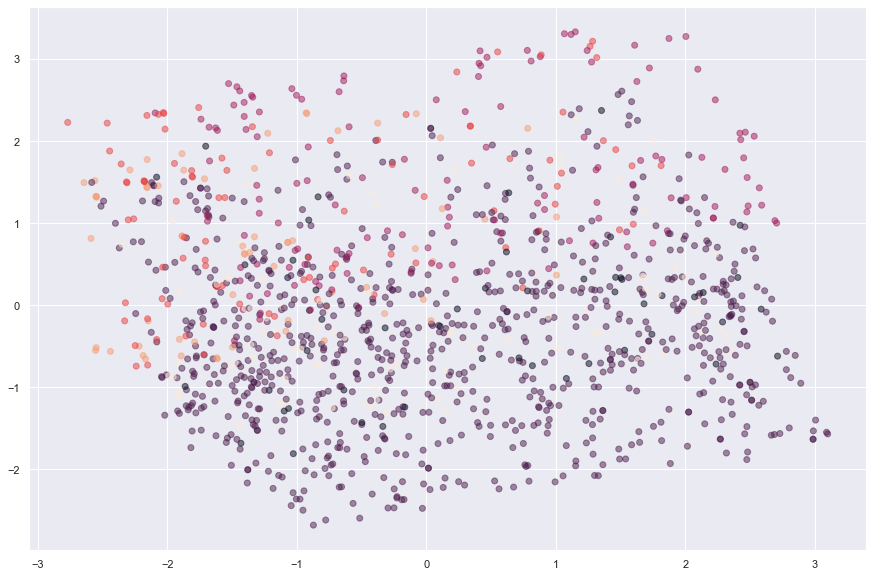

In [287]:
plt.figure(figsize=(15,10))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.Series(clusters), alpha=.5)

### t-SNE

In [288]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1272 samples in 0.002s...
[t-SNE] Computed neighbors for 1272 samples in 0.084s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1272
[t-SNE] Computed conditional probabilities for sample 1272 / 1272
[t-SNE] Mean sigma: 1.932726
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.344837
[t-SNE] KL divergence after 300 iterations: 0.451688


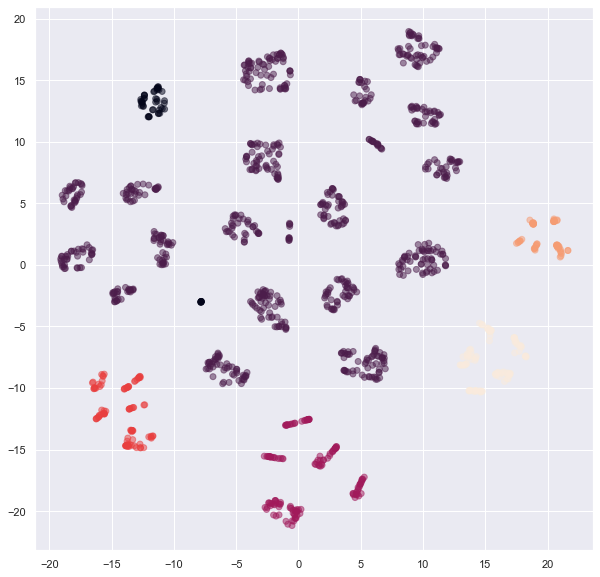

In [289]:
plt.figure(figsize=(10, 10))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=.5, c=pd.Series(clusters))

### UMAP - iteration 1

In [290]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

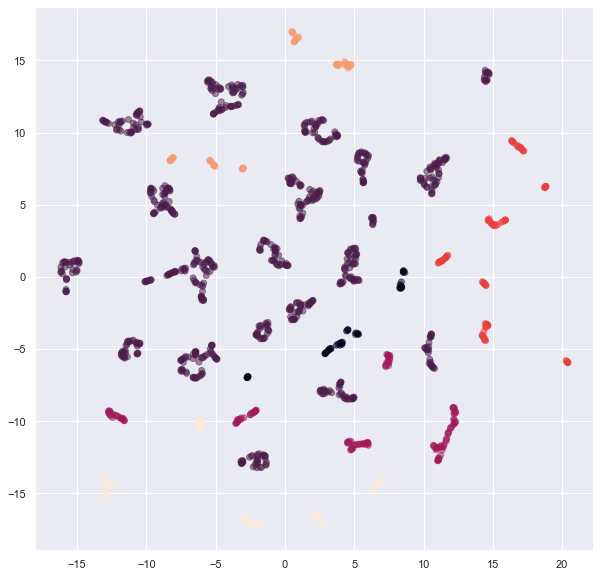

In [291]:
plt.figure(figsize=(10, 10))

plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=.5, c=pd.Series(clusters))

# Beat #11 - all the beats other than 16 seemed to have silhouette scores similar to each other, I picked beat 11 to examine and contrast with beat 16 above

In [258]:
beat_11 = df[df.beat == 11]

In [259]:
beat_11

,beat,charge_description,month,day_of_week,week_of_year,hour_of_day,age_breaks
5,11.0,Expired/No Arizona Registration,7,4,27,23,"(39.0, 51.0]"
17,11.0,Expired/No Arizona Registration,7,4,27,19,"(51.0, 97.0]"
32,11.0,No Proof of Insurance,7,6,27,18,"(17.999, 24.0]"
36,11.0,Speed Greater Than R&P or Posted,7,5,28,21,"(17.999, 24.0]"
47,11.0,Speed Greater Than R&P or Posted,7,1,28,6,"(17.999, 24.0]"
...,...,...,...,...,...,...,...
36523,11.0,No Proof of Insurance,9,6,39,14,"(51.0, 97.0]"
36530,11.0,Expired/No Arizona Registration,9,3,39,17,"(51.0, 97.0]"
36532,11.0,No Proof of Insurance,9,3,39,23,"(17.999, 24.0]"
36565,11.0,Speed Greater Than R&P or Posted,9,4,39,23,"(17.999, 24.0]"


In [260]:
# df2 = df[df.beat == location]
X = pd.get_dummies(beat_11.drop(['beat'], axis=1))

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=4, min_samples=20)

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)
pd.Series(clusters).value_counts()

 0    851
 1    159
 4    127
 5    115
 6    114
 2     80
 3     54
-1     24
dtype: int64

In [261]:
pd.Series(clusters).shape

(1524,)

In [262]:
beat_11_labels = pd.concat([beat_11.reset_index(), pd.Series(clusters)], axis=1)

In [263]:
beat_11_labels[beat_11_labels[0] == 2]

,index,beat,charge_description,month,day_of_week,week_of_year,hour_of_day,age_breaks,0
6,80,11.0,Fail to Stop For Red Signal,7,1,28,5,"(51.0, 97.0]",2
60,1429,11.0,Fail to Stop For Red Signal,7,5,29,1,"(30.0, 39.0]",2
68,1612,11.0,Fail to Stop For Red Signal,3,4,13,14,"(24.0, 30.0]",2
132,2943,11.0,Fail to Stop For Red Signal,11,6,45,21,"(51.0, 97.0]",2
198,4492,11.0,Fail to Stop For Red Signal,4,4,17,6,"(30.0, 39.0]",2
...,...,...,...,...,...,...,...,...,...
1420,34664,11.0,Fail to Stop For Red Signal,12,2,49,22,"(39.0, 51.0]",2
1463,35578,11.0,Fail to Stop For Red Signal,12,0,51,20,"(24.0, 30.0]",2
1468,35690,11.0,Fail to Stop For Red Signal,12,0,52,21,"(30.0, 39.0]",2
1498,36210,11.0,Fail to Stop For Red Signal,9,2,38,16,"(51.0, 97.0]",2


In [264]:
beat_11_labels[beat_11_labels[0] == 1]

,index,beat,charge_description,month,day_of_week,week_of_year,hour_of_day,age_breaks,0
2,32,11.0,No Proof of Insurance,7,6,27,18,"(17.999, 24.0]",1
11,145,11.0,No Proof of Insurance,7,4,28,22,"(24.0, 30.0]",1
15,205,11.0,No Proof of Insurance,3,4,12,23,"(30.0, 39.0]",1
19,268,11.0,No Proof of Insurance,3,2,12,18,"(51.0, 97.0]",1
47,1067,11.0,No Proof of Insurance,7,3,29,19,"(24.0, 30.0]",1
...,...,...,...,...,...,...,...,...,...
1490,36028,11.0,No Proof of Insurance,1,6,1,12,"(51.0, 97.0]",1
1495,36097,11.0,No Proof of Insurance,1,1,2,18,"(30.0, 39.0]",1
1519,36523,11.0,No Proof of Insurance,9,6,39,14,"(51.0, 97.0]",1
1521,36532,11.0,No Proof of Insurance,9,3,39,23,"(17.999, 24.0]",1


In [265]:
beat_11_labels[beat_11_labels[0] == 0]

,index,beat,charge_description,month,day_of_week,week_of_year,hour_of_day,age_breaks,0
0,5,11.0,Expired/No Arizona Registration,7,4,27,23,"(39.0, 51.0]",0
1,17,11.0,Expired/No Arizona Registration,7,4,27,19,"(51.0, 97.0]",0
3,36,11.0,Speed Greater Than R&P or Posted,7,5,28,21,"(17.999, 24.0]",0
4,47,11.0,Speed Greater Than R&P or Posted,7,1,28,6,"(17.999, 24.0]",0
5,71,11.0,Expired/No Arizona Registration,7,1,28,11,"(30.0, 39.0]",0
...,...,...,...,...,...,...,...,...,...
1516,36457,11.0,Speed Greater Than R&P or Posted,9,6,38,10,"(39.0, 51.0]",0
1517,36464,11.0,Expired/No Arizona Registration,9,6,38,14,"(51.0, 97.0]",0
1518,36484,11.0,Speed Greater Than R&P or Posted,9,3,39,0,"(30.0, 39.0]",0
1520,36530,11.0,Expired/No Arizona Registration,9,3,39,17,"(51.0, 97.0]",0


In [266]:
X = pd.get_dummies(beat_11.drop('beat', axis=1))

In [267]:
X.head()

,month,day_of_week,week_of_year,hour_of_day,charge_description_DUI-Impaired to Slightest Degree,charge_description_Drug Paraphernalia-Possess/Use,charge_description_Expired/No Arizona Registration,charge_description_Fail to Obey Traffic Control Device,charge_description_Fail to Stop For Red Signal,charge_description_Fail to Stop at Stop Sign,charge_description_Failure to Control Speed to Avoid A Collision,charge_description_No Proof of Insurance,charge_description_Speed Greater Than R&P or Posted,charge_description_Suspended/Revoked D.L.,"age_breaks_(17.999, 24.0]","age_breaks_(24.0, 30.0]","age_breaks_(30.0, 39.0]","age_breaks_(39.0, 51.0]","age_breaks_(51.0, 97.0]"
5,7,4,27,23,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
17,7,4,27,19,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
32,7,6,27,18,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
36,7,5,28,21,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
47,7,1,28,6,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [268]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

### PCA

In [269]:
# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

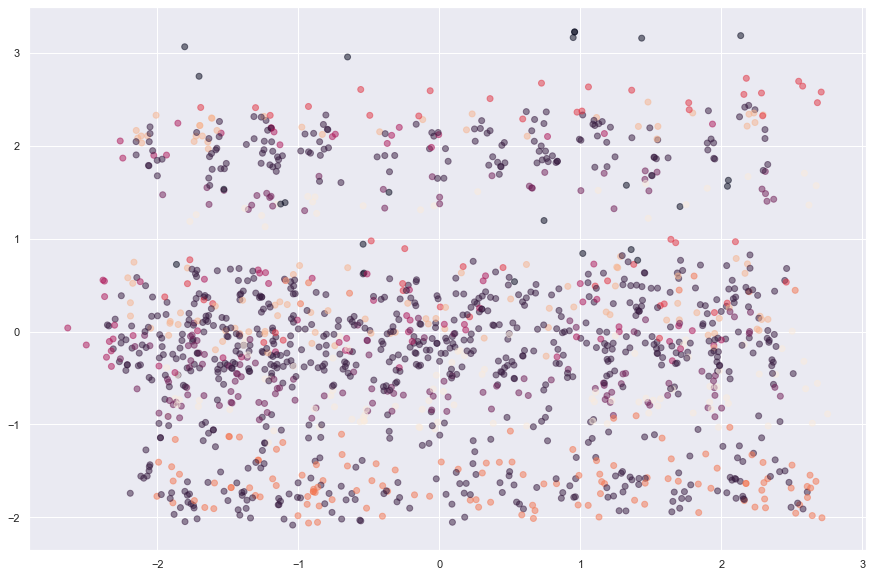

In [270]:
plt.figure(figsize=(15,10))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.Series(clusters), alpha=.5)

### t-SNE

In [271]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1524 samples in 0.003s...
[t-SNE] Computed neighbors for 1524 samples in 0.108s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1524
[t-SNE] Computed conditional probabilities for sample 1524 / 1524
[t-SNE] Mean sigma: 1.804101
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.822086
[t-SNE] KL divergence after 300 iterations: 0.500538


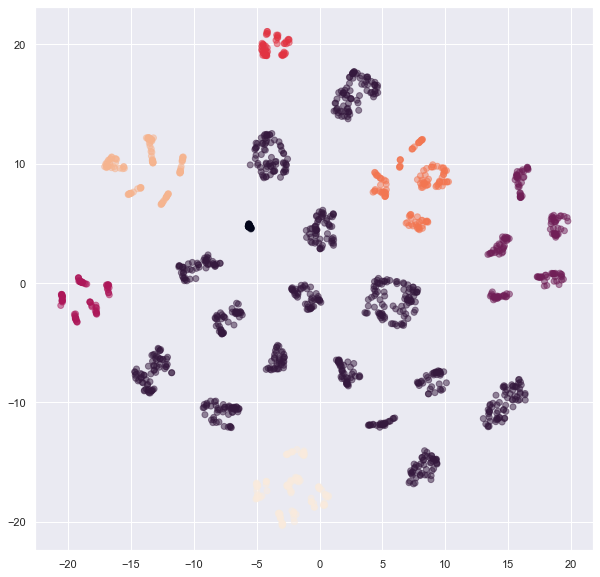

In [272]:
plt.figure(figsize=(10, 10))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=.5, c=pd.Series(clusters))

### UMAP - iteration 1

In [273]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

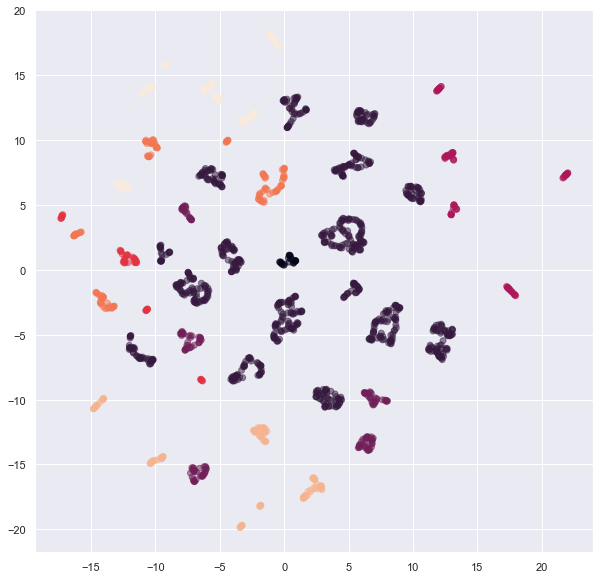

In [274]:
plt.figure(figsize=(10, 10))

plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=.5, c=pd.Series(clusters))

# Reperform the above, but using age as a continuous feature

In [293]:
# read in data that has already been preprocessed
df = pd.read_csv('data/clustering_features.csv')

In [294]:
df.shape

(36626, 11)

In [295]:
df.head()

,beat,cited_person_age,citation_time,charge_description,street,month,day_of_week,week_of_year,hour_of_day,place_id,age_breaks
0,12.0,19.0,747,Speed Greater Than R&P or Posted,E Shea Bl,7,2,28,7,E Shea Bl - 6xxx,"(17.999, 24.0]"
1,12.0,36.0,800,Speed Greater Than R&P or Posted,E Shea Bl,7,2,28,8,E Shea Bl - 6xxx,"(30.0, 39.0]"
2,7.0,61.0,853,Speed Greater Than R&P or Posted,N Goldwater Bl,7,2,28,8,N Goldwater Bl - 4xxx,"(51.0, 97.0]"
3,7.0,59.0,843,Speed Greater Than R&P or Posted,N Goldwater Bl,7,3,28,8,N Goldwater Bl - 4xxx,"(51.0, 97.0]"
4,19.0,23.0,2215,Speed Greater Than R&P or Posted,N Pima Rd,7,5,27,22,N Pima Rd - 2xxx,"(17.999, 24.0]"


In [296]:
# drop place id for the time being
df.drop(['place_id'], axis=1, inplace=True)

In [297]:
# drop features I don't want to use for now
df.drop(['citation_time'], axis=1, inplace=True)
# df.drop(['age_breaks'], axis=1, inplace=True)
# df.drop(['beat'], axis=1, inplace=True)
df.drop(['age_breaks'], axis=1, inplace=True)

In [298]:
df.drop(['street'], axis=1, inplace=True)

In [299]:
# drop citations where beat is null
# otherwise this creates problems for modeling

df.drop(df[df.beat.isnull()].index, inplace=True)

In [300]:
# verify no null values remain
df.isnull().sum()

beat                  0
cited_person_age      0
charge_description    0
month                 0
day_of_week           0
week_of_year          0
hour_of_day           0
dtype: int64

In [301]:
df.head()

,beat,cited_person_age,charge_description,month,day_of_week,week_of_year,hour_of_day
0,12.0,19.0,Speed Greater Than R&P or Posted,7,2,28,7
1,12.0,36.0,Speed Greater Than R&P or Posted,7,2,28,8
2,7.0,61.0,Speed Greater Than R&P or Posted,7,2,28,8
3,7.0,59.0,Speed Greater Than R&P or Posted,7,3,28,8
4,19.0,23.0,Speed Greater Than R&P or Posted,7,5,27,22


In [302]:
# identify unique beat locations
df.beat.unique()

array([12.,  7., 19., 11.,  6., 14., 10., 18.,  3., 15.,  1., 16., 17.,
       13., 99.,  4., 20.,  8.,  5.,  9.,  2.])

In [303]:
X = pd.get_dummies(df.drop(['beat'], axis=1))

In [304]:
X.head()

,cited_person_age,month,day_of_week,week_of_year,hour_of_day,charge_description_DUI-Impaired to Slightest Degree,charge_description_Drug Paraphernalia-Possess/Use,charge_description_Expired/No Arizona Registration,charge_description_Fail to Obey Traffic Control Device,charge_description_Fail to Stop For Red Signal,charge_description_Fail to Stop at Stop Sign,charge_description_Failure to Control Speed to Avoid A Collision,charge_description_No Proof of Insurance,charge_description_Speed Greater Than R&P or Posted,charge_description_Suspended/Revoked D.L.
0,19.0,7,2,28,7,0,0,0,0,0,0,0,0,1,0
1,36.0,7,2,28,8,0,0,0,0,0,0,0,0,1,0
2,61.0,7,2,28,8,0,0,0,0,0,0,0,0,1,0
3,59.0,7,3,28,8,0,0,0,0,0,0,0,0,1,0
4,23.0,7,5,27,22,0,0,0,0,0,0,0,0,1,0


In [305]:
X.shape

(36391, 15)

In [306]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [307]:
sil_score = []
cluster_count = []

for location in list(df.beat.unique()):
    
    df2 = df[df.beat == location]
    X = pd.get_dummies(df2.drop(['beat'], axis=1))
    
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    
    # Defining the agglomerative clustering
    dbscan_cluster = DBSCAN(eps=.5, min_samples=5)

    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    
    # capture cluster count
    cluster_count.append(len(set(clusters)) - (1 if -1 in clusters else 0))

    # capture model fit
    if pd.Series(clusters).nunique() > 1:
        sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))
    else:
        sil_score.append(np.nan)

In [308]:
list(zip(list(df.beat.unique()), sil_score, cluster_count))

[(12.0, -0.288, 12),
 (7.0, -0.341, 42),
 (19.0, -0.322, 53),
 (11.0, -0.23, 2),
 (6.0, -0.355, 65),
 (14.0, -0.31, 18),
 (10.0, -0.302, 36),
 (18.0, -0.289, 17),
 (3.0, -0.459, 45),
 (15.0, -0.34, 22),
 (1.0, -0.294, 13),
 (16.0, -0.156, 1),
 (17.0, -0.252, 28),
 (13.0, -0.31, 10),
 (99.0, nan, 0),
 (4.0, -0.276, 23),
 (20.0, -0.317, 23),
 (8.0, -0.28, 13),
 (5.0, -0.239, 12),
 (9.0, -0.289, 7),
 (2.0, -0.221, 9)]

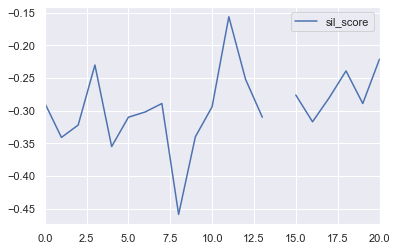

In [309]:
pd.DataFrame(list(zip(list(df.beat.unique()), sil_score, cluster_count)), 
            columns=['beat', 'sil_score', 'cluster_count']).loc[:,['sil_score']].plot()

# plt.ylabel('Score Index')
# plt.xlabel('Clusters')
# plt.xticks(rotation=45);

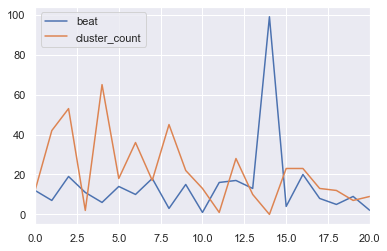

In [310]:
pd.DataFrame(list(zip(list(df.beat.unique()), sil_score, cluster_count)), 
            columns=['beat', 'sil_score', 'cluster_count']).loc[:,['beat','cluster_count']].plot()

# plt.ylabel('Score Index')
# plt.xlabel('Clusters')
# plt.xticks(rotation=45);

## Beat #16 seems to show the tightest clustering

In [311]:
beat_16 = df[df.beat == 16]

In [312]:
beat_16

,beat,cited_person_age,charge_description,month,day_of_week,week_of_year,hour_of_day
20,16.0,30.0,Drug Paraphernalia-Possess/Use,7,0,29,22
89,16.0,26.0,Expired/No Arizona Registration,7,5,28,12
123,16.0,35.0,Speed Greater Than R&P or Posted,7,3,28,4
135,16.0,30.0,Suspended/Revoked D.L.,7,2,29,23
160,16.0,18.0,Speed Greater Than R&P or Posted,7,2,28,12
...,...,...,...,...,...,...,...
36551,16.0,56.0,Fail to Obey Traffic Control Device,9,3,39,13
36553,16.0,45.0,Fail to Obey Traffic Control Device,9,3,39,13
36587,16.0,28.0,Speed Greater Than R&P or Posted,9,2,39,7
36589,16.0,61.0,Failure to Control Speed to Avoid A Collision,10,2,40,15


In [313]:
X = pd.get_dummies(beat_16.drop(['beat'], axis=1))

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=4, min_samples=40)

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)
pd.Series(clusters).value_counts()

 0    832
 1    139
 3     94
 2     91
 5     63
 4     44
-1      9
dtype: int64

In [314]:
pd.Series(clusters).shape

(1272,)

In [315]:
beat_16_labels = pd.concat([beat_16.reset_index(), pd.Series(clusters)], axis=1)

In [316]:
beat_16_labels[beat_16_labels[0] == 2]

,index,beat,cited_person_age,charge_description,month,day_of_week,week_of_year,hour_of_day,0
9,510,16.0,46.0,No Proof of Insurance,10,6,43,23,2
19,739,16.0,36.0,No Proof of Insurance,7,6,28,22,2
52,1636,16.0,18.0,No Proof of Insurance,3,5,13,23,2
56,1688,16.0,20.0,No Proof of Insurance,11,4,44,23,2
57,1711,16.0,29.0,No Proof of Insurance,11,4,44,23,2
...,...,...,...,...,...,...,...,...,...
1214,35600,16.0,82.0,No Proof of Insurance,12,3,52,17,2
1215,35630,16.0,28.0,No Proof of Insurance,12,3,52,23,2
1228,35776,16.0,30.0,No Proof of Insurance,12,4,52,9,2
1256,36304,16.0,46.0,No Proof of Insurance,9,4,39,0,2


In [317]:
beat_16_labels[beat_16_labels[0] == 1]

,index,beat,cited_person_age,charge_description,month,day_of_week,week_of_year,hour_of_day,0
7,443,16.0,37.0,Failure to Control Speed to Avoid A Collision,10,2,44,11,1
22,774,16.0,32.0,Failure to Control Speed to Avoid A Collision,7,2,29,18,1
27,921,16.0,33.0,Failure to Control Speed to Avoid A Collision,4,0,14,19,1
37,1196,16.0,33.0,Failure to Control Speed to Avoid A Collision,11,2,45,15,1
48,1575,16.0,66.0,Failure to Control Speed to Avoid A Collision,4,2,14,7,1
...,...,...,...,...,...,...,...,...,...
1241,36012,16.0,26.0,Failure to Control Speed to Avoid A Collision,1,6,1,11,1
1243,36049,16.0,20.0,Failure to Control Speed to Avoid A Collision,1,4,2,18,1
1251,36235,16.0,59.0,Failure to Control Speed to Avoid A Collision,9,6,38,13,1
1255,36256,16.0,37.0,Failure to Control Speed to Avoid A Collision,9,1,39,20,1


In [318]:
beat_16_labels[beat_16_labels[0] == 0]

,index,beat,cited_person_age,charge_description,month,day_of_week,week_of_year,hour_of_day,0
0,20,16.0,30.0,Drug Paraphernalia-Possess/Use,7,0,29,22,0
1,89,16.0,26.0,Expired/No Arizona Registration,7,5,28,12,0
2,123,16.0,35.0,Speed Greater Than R&P or Posted,7,3,28,4,0
3,135,16.0,30.0,Suspended/Revoked D.L.,7,2,29,23,0
4,160,16.0,18.0,Speed Greater Than R&P or Posted,7,2,28,12,0
...,...,...,...,...,...,...,...,...,...
1262,36433,16.0,25.0,Speed Greater Than R&P or Posted,9,5,38,11,0
1264,36494,16.0,63.0,Expired/No Arizona Registration,9,1,39,13,0
1266,36549,16.0,55.0,Speed Greater Than R&P or Posted,9,4,39,7,0
1269,36587,16.0,28.0,Speed Greater Than R&P or Posted,9,2,39,7,0


In [319]:
X = pd.get_dummies(beat_16.drop('beat', axis=1))

In [320]:
X.head()

,cited_person_age,month,day_of_week,week_of_year,hour_of_day,charge_description_DUI-Impaired to Slightest Degree,charge_description_Drug Paraphernalia-Possess/Use,charge_description_Expired/No Arizona Registration,charge_description_Fail to Obey Traffic Control Device,charge_description_Fail to Stop For Red Signal,charge_description_Fail to Stop at Stop Sign,charge_description_Failure to Control Speed to Avoid A Collision,charge_description_No Proof of Insurance,charge_description_Speed Greater Than R&P or Posted,charge_description_Suspended/Revoked D.L.
20,30.0,7,0,29,22,0,1,0,0,0,0,0,0,0,0
89,26.0,7,5,28,12,0,0,1,0,0,0,0,0,0,0
123,35.0,7,3,28,4,0,0,0,0,0,0,0,0,1,0
135,30.0,7,2,29,23,0,0,0,0,0,0,0,0,0,1
160,18.0,7,2,28,12,0,0,0,0,0,0,0,0,1,0


In [321]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

### PCA

In [322]:
# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

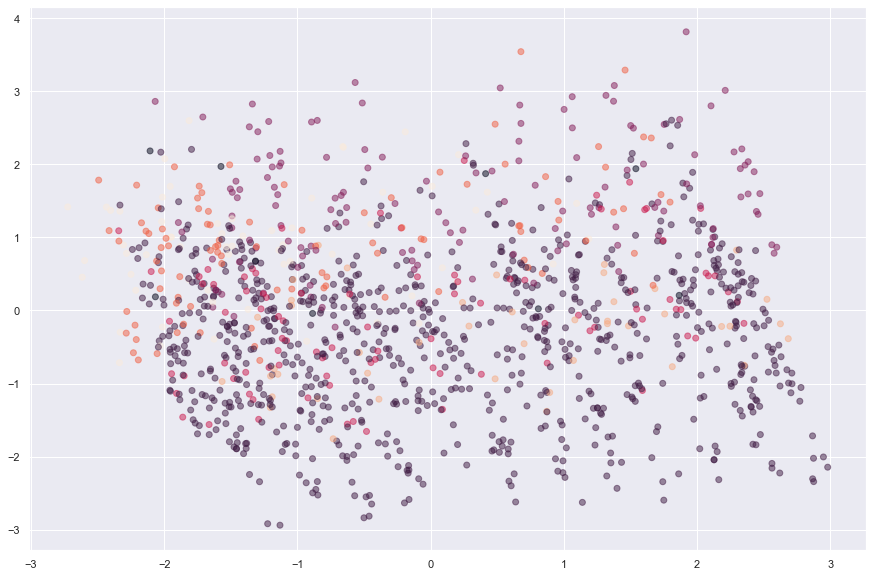

In [323]:
plt.figure(figsize=(15,10))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.Series(clusters), alpha=.5)

### t-SNE

In [324]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1272 samples in 0.003s...
[t-SNE] Computed neighbors for 1272 samples in 0.076s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1272
[t-SNE] Computed conditional probabilities for sample 1272 / 1272
[t-SNE] Mean sigma: 1.205518
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.443829
[t-SNE] KL divergence after 300 iterations: 0.629415


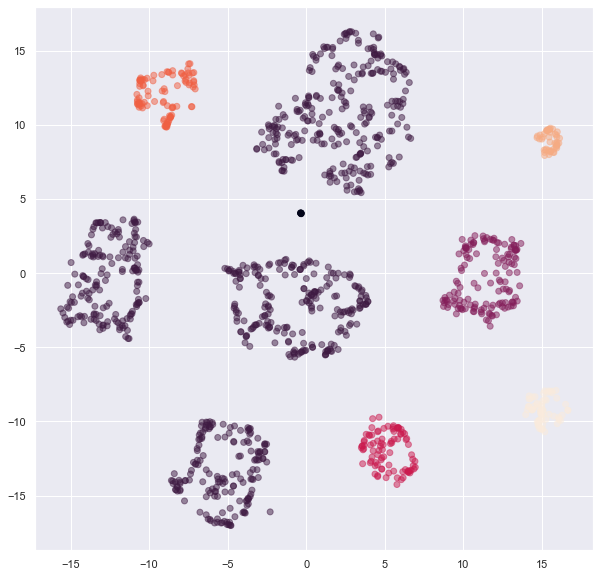

In [325]:
plt.figure(figsize=(10, 10))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=.5, c=pd.Series(clusters))

### UMAP - iteration 1

In [326]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

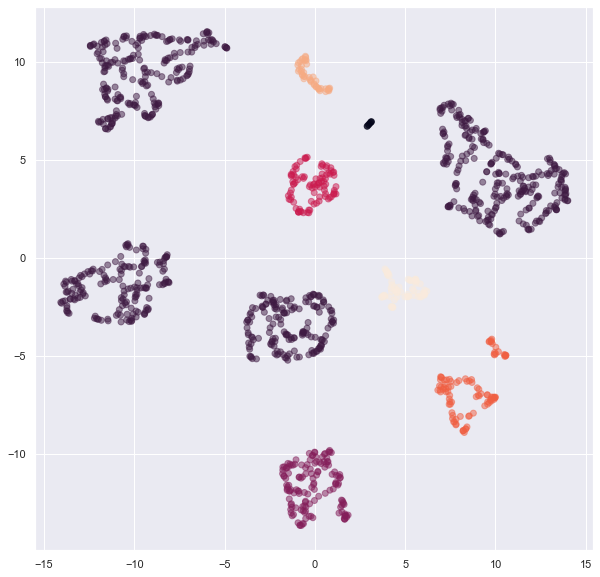

In [327]:
plt.figure(figsize=(10, 10))

plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=.5, c=pd.Series(clusters))

# Beat #11 - all the beats other than 16 seemed to have silhouette scores similar to each other, I picked beat 11 to examine and contrast with beat 16 above

In [328]:
beat_11 = df[df.beat == 11]

In [329]:
beat_11

,beat,cited_person_age,charge_description,month,day_of_week,week_of_year,hour_of_day
5,11.0,43.0,Expired/No Arizona Registration,7,4,27,23
17,11.0,55.0,Expired/No Arizona Registration,7,4,27,19
32,11.0,22.0,No Proof of Insurance,7,6,27,18
36,11.0,24.0,Speed Greater Than R&P or Posted,7,5,28,21
47,11.0,21.0,Speed Greater Than R&P or Posted,7,1,28,6
...,...,...,...,...,...,...,...
36523,11.0,86.0,No Proof of Insurance,9,6,39,14
36530,11.0,72.0,Expired/No Arizona Registration,9,3,39,17
36532,11.0,23.0,No Proof of Insurance,9,3,39,23
36565,11.0,23.0,Speed Greater Than R&P or Posted,9,4,39,23


In [330]:
# df2 = df[df.beat == location]
X = pd.get_dummies(beat_11.drop(['beat'], axis=1))

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=4, min_samples=20)

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)
pd.Series(clusters).value_counts()

0    851
1    159
4    127
5    115
6    114
2     80
3     54
7     24
dtype: int64

In [331]:
pd.Series(clusters).shape

(1524,)

In [332]:
beat_11_labels = pd.concat([beat_11.reset_index(), pd.Series(clusters)], axis=1)

In [333]:
beat_11_labels[beat_11_labels[0] == 2]

,index,beat,cited_person_age,charge_description,month,day_of_week,week_of_year,hour_of_day,0
6,80,11.0,57.0,Fail to Stop For Red Signal,7,1,28,5,2
60,1429,11.0,35.0,Fail to Stop For Red Signal,7,5,29,1,2
68,1612,11.0,26.0,Fail to Stop For Red Signal,3,4,13,14,2
132,2943,11.0,57.0,Fail to Stop For Red Signal,11,6,45,21,2
198,4492,11.0,38.0,Fail to Stop For Red Signal,4,4,17,6,2
...,...,...,...,...,...,...,...,...,...
1420,34664,11.0,48.0,Fail to Stop For Red Signal,12,2,49,22,2
1463,35578,11.0,27.0,Fail to Stop For Red Signal,12,0,51,20,2
1468,35690,11.0,38.0,Fail to Stop For Red Signal,12,0,52,21,2
1498,36210,11.0,69.0,Fail to Stop For Red Signal,9,2,38,16,2


In [334]:
beat_11_labels[beat_11_labels[0] == 1]

,index,beat,cited_person_age,charge_description,month,day_of_week,week_of_year,hour_of_day,0
2,32,11.0,22.0,No Proof of Insurance,7,6,27,18,1
11,145,11.0,29.0,No Proof of Insurance,7,4,28,22,1
15,205,11.0,37.0,No Proof of Insurance,3,4,12,23,1
19,268,11.0,57.0,No Proof of Insurance,3,2,12,18,1
47,1067,11.0,28.0,No Proof of Insurance,7,3,29,19,1
...,...,...,...,...,...,...,...,...,...
1490,36028,11.0,63.0,No Proof of Insurance,1,6,1,12,1
1495,36097,11.0,34.0,No Proof of Insurance,1,1,2,18,1
1519,36523,11.0,86.0,No Proof of Insurance,9,6,39,14,1
1521,36532,11.0,23.0,No Proof of Insurance,9,3,39,23,1


In [335]:
beat_11_labels[beat_11_labels[0] == 0]

,index,beat,cited_person_age,charge_description,month,day_of_week,week_of_year,hour_of_day,0
0,5,11.0,43.0,Expired/No Arizona Registration,7,4,27,23,0
1,17,11.0,55.0,Expired/No Arizona Registration,7,4,27,19,0
3,36,11.0,24.0,Speed Greater Than R&P or Posted,7,5,28,21,0
4,47,11.0,21.0,Speed Greater Than R&P or Posted,7,1,28,6,0
5,71,11.0,37.0,Expired/No Arizona Registration,7,1,28,11,0
...,...,...,...,...,...,...,...,...,...
1516,36457,11.0,40.0,Speed Greater Than R&P or Posted,9,6,38,10,0
1517,36464,11.0,66.0,Expired/No Arizona Registration,9,6,38,14,0
1518,36484,11.0,39.0,Speed Greater Than R&P or Posted,9,3,39,0,0
1520,36530,11.0,72.0,Expired/No Arizona Registration,9,3,39,17,0


In [336]:
X = pd.get_dummies(beat_11.drop('beat', axis=1))

In [337]:
X.head()

,cited_person_age,month,day_of_week,week_of_year,hour_of_day,charge_description_DUI-Impaired to Slightest Degree,charge_description_Drug Paraphernalia-Possess/Use,charge_description_Expired/No Arizona Registration,charge_description_Fail to Obey Traffic Control Device,charge_description_Fail to Stop For Red Signal,charge_description_Fail to Stop at Stop Sign,charge_description_Failure to Control Speed to Avoid A Collision,charge_description_No Proof of Insurance,charge_description_Speed Greater Than R&P or Posted,charge_description_Suspended/Revoked D.L.
5,43.0,7,4,27,23,0,0,1,0,0,0,0,0,0,0
17,55.0,7,4,27,19,0,0,1,0,0,0,0,0,0,0
32,22.0,7,6,27,18,0,0,0,0,0,0,0,1,0,0
36,24.0,7,5,28,21,0,0,0,0,0,0,0,0,1,0
47,21.0,7,1,28,6,0,0,0,0,0,0,0,0,1,0


In [338]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

### PCA

In [339]:
# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

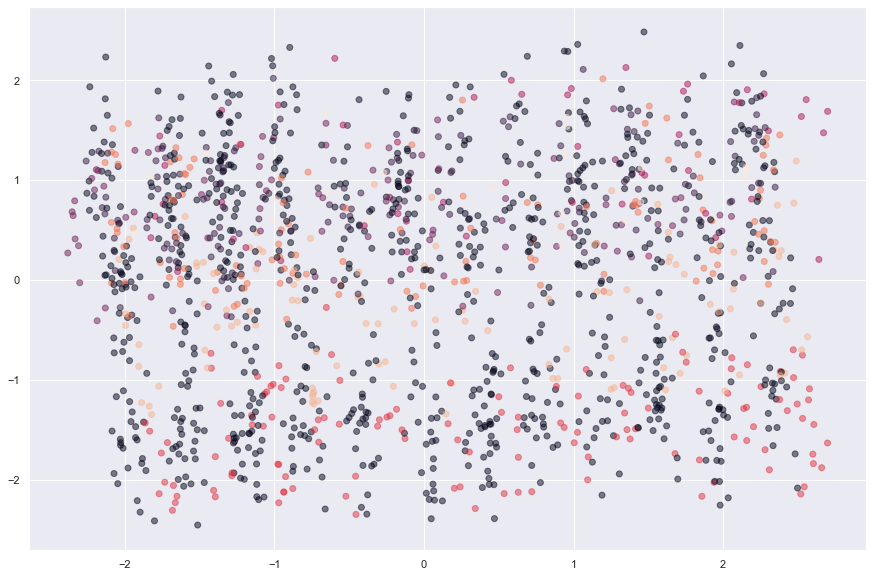

In [340]:
plt.figure(figsize=(15,10))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.Series(clusters), alpha=.5)

### t-SNE

In [341]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1524 samples in 0.003s...
[t-SNE] Computed neighbors for 1524 samples in 0.103s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1524
[t-SNE] Computed conditional probabilities for sample 1524 / 1524
[t-SNE] Mean sigma: 1.113988
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.418736
[t-SNE] KL divergence after 300 iterations: 0.734969


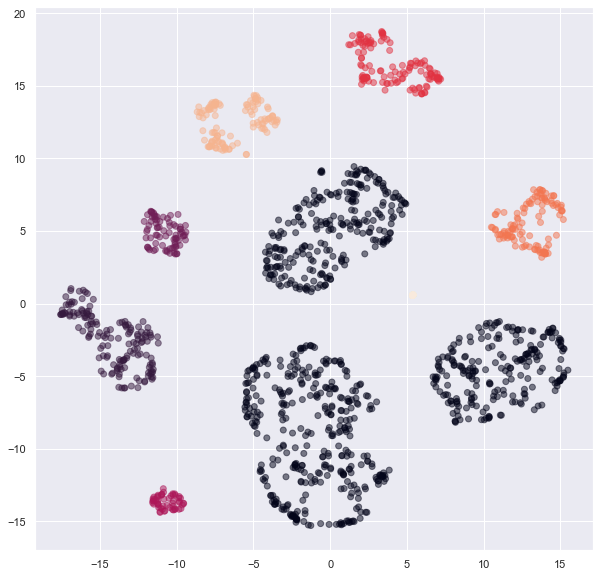

In [342]:
plt.figure(figsize=(10, 10))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=.5, c=pd.Series(clusters))

### UMAP - iteration 1

In [343]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

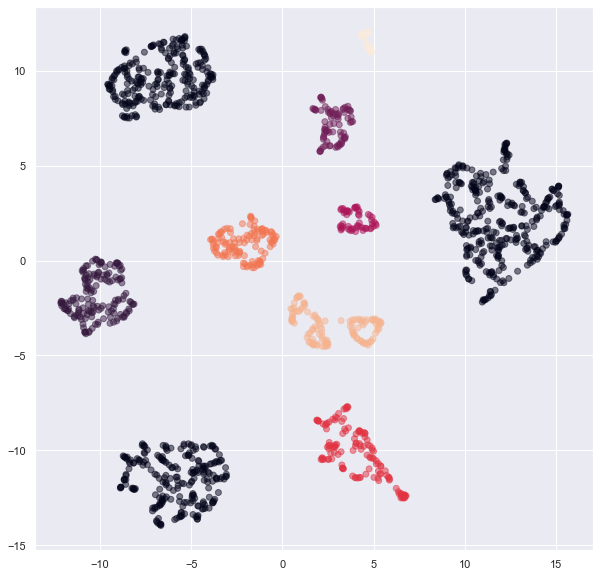

In [344]:
plt.figure(figsize=(10, 10))

plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=.5, c=pd.Series(clusters))